In [6]:
import pandas as pd
import numpy as np
import torch

# Load the labels
labels = pd.read_csv('labelele.csv')['Names'].tolist()
labels = [label.strip() for label in labels]  # Strip whitespace from labels

# Create a mapping from labels to indices
label_to_index = {label: idx for idx, label in enumerate(labels)}

# Load the models
transr_model = torch.load('transr_model.pth')
transe_model = torch.load('transe_model.pth')

def get_top_recommendation(model, node, labels, label_to_index):
    relation = 'connected_to'
    possible_triples = np.array([[node, relation, target] for target in labels if target != node])
    possible_triples_indices = np.array([[label_to_index[h], 0, label_to_index[t]] for h, r, t in possible_triples])
    possible_triples_tensor = torch.tensor(possible_triples_indices, dtype=torch.long)
    scores = model.predict_hrt(possible_triples_tensor)
    scores_np = scores.detach().numpy()
    top_index = np.argmax(scores_np)
    top_triple = possible_triples_indices[top_index]
    similar_node = labels[top_triple[2]]
    return similar_node

# Get recommendations for each node using both models
recommendations = {'TransE': {}, 'TransR': {}}
for node in labels:
    recommendations['TransE'][node] = get_top_recommendation(transe_model, node, labels, label_to_index)
    recommendations['TransR'][node] = get_top_recommendation(transr_model, node, labels, label_to_index)

# Print recommendations for verification
print("TransE Recommendations:", recommendations['TransE'])
print("TransR Recommendations:", recommendations['TransR'])

TransE Recommendations: {'vishesh': 'poonam', 'shrestha': 'poonam', 'biswajeet': 'priyanka', 'priyanka': 'poonam', 'poonam': 'shrestha', 'adhiraaj': 'poonam', 'yash': 'shrestha', 'sachin': 'sai', 'vinayak': 'priyanka', 'kranti': 'poonam', 'sai': 'priyanka'}
TransR Recommendations: {'vishesh': 'adhiraaj', 'shrestha': 'vishesh', 'biswajeet': 'vishesh', 'priyanka': 'vishesh', 'poonam': 'vishesh', 'adhiraaj': 'vishesh', 'yash': 'vishesh', 'sachin': 'vishesh', 'vinayak': 'vishesh', 'kranti': 'vishesh', 'sai': 'vishesh'}


In [3]:
import numpy as np
import vish_graphs as vg
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import core_rec as cs
import matplotlib.pyplot as plt
from matplotlib.table import Table

# Load the CSV file into a DataFrame
adj_matrix = np.loadtxt('label.csv', delimiter=",")

# Load node labels
df = pd.read_csv("labelele.csv")
col = df.values.flatten()
node_labels = {i: label for i, label in enumerate(col)}
label_to_index = {label: i for i, label in enumerate(col)}  # Create a reverse mapping

# Print available labels for debugging
print("Available labels:", list(label_to_index.keys()))

# Find top nodes
top_nodes = vg.find_top_nodes(adj_matrix, 4)

# ML
# Convert adjacency matrix to dataset
graph_dataset = cs.GraphDataset(adj_matrix)
batch_size = 3
var = 1.0

# Initialize model parameters
num_layers = 1
d_model = 128  # embedding dimension
num_heads = 2
d_feedforward = 512
input_dim = adj_matrix.shape[1]  # Ensure input_dim matches the number of features in adj_matrix
num_weights = 10

# Initialize model, loss function, and optimizer
model = cs.GraphTransformer(num_layers, d_model, num_heads, d_feedforward, input_dim, use_weights=True)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Create DataLoader
data_loader = DataLoader(graph_dataset, batch_size=batch_size, shuffle=True)

# Train the model
num_epochs = 100
cs.train_model(model, data_loader, criterion, optimizer, num_epochs)

# Recommend nodes for a target node
target_node_label = "vishesh"  # Example target node label

# Check if the target node label exists
if target_node_label in label_to_index:
    target_node_index = label_to_index[target_node_label]  # Get the index of the target node
    recommended_nodes = cs.predict(model, adj_matrix, target_node_index, top_k=3, threshold=1)

    # Map recommended node indices to labels
    recommended_labels = [node_labels[idx] for idx in recommended_nodes]

    print(f"Recommended nodes for target node {target_node_label}: {recommended_labels}")
else:
    print(f"Error: The label '{target_node_label}' does not exist. Available labels are: {list(label_to_index.keys())}")

Available labels: ['vishesh', 'shrestha', 'biswajeet', 'priyanka', 'poonam', 'adhiraaj', 'yash', 'sachin', 'vinayak', 'kranti', 'sai']
The top 4 nodes with the greatest number of strong correlations are: [6, 8, 0, 3]
Epoch 1/100, Loss: 15.196966171264648
Epoch 2/100, Loss: 20.63846206665039
Epoch 3/100, Loss: 13.582907676696777
Epoch 4/100, Loss: 13.889812469482422
Epoch 5/100, Loss: 12.935437202453613
Epoch 6/100, Loss: 17.518957138061523
Epoch 7/100, Loss: 17.31910514831543
Epoch 8/100, Loss: 11.099188804626465
Epoch 9/100, Loss: 14.421868324279785
Epoch 10/100, Loss: 9.814393043518066
Epoch 11/100, Loss: 12.058816909790039
Epoch 12/100, Loss: 10.492867469787598
Epoch 13/100, Loss: 11.040221214294434
Epoch 14/100, Loss: 8.254744529724121
Epoch 15/100, Loss: 7.227804183959961
Epoch 16/100, Loss: 12.081612586975098
Epoch 17/100, Loss: 8.186203956604004
Epoch 18/100, Loss: 12.206360816955566
Epoch 19/100, Loss: 8.03018569946289
Epoch 20/100, Loss: 6.5150980949401855
Epoch 21/100, Loss: 

# Comparision

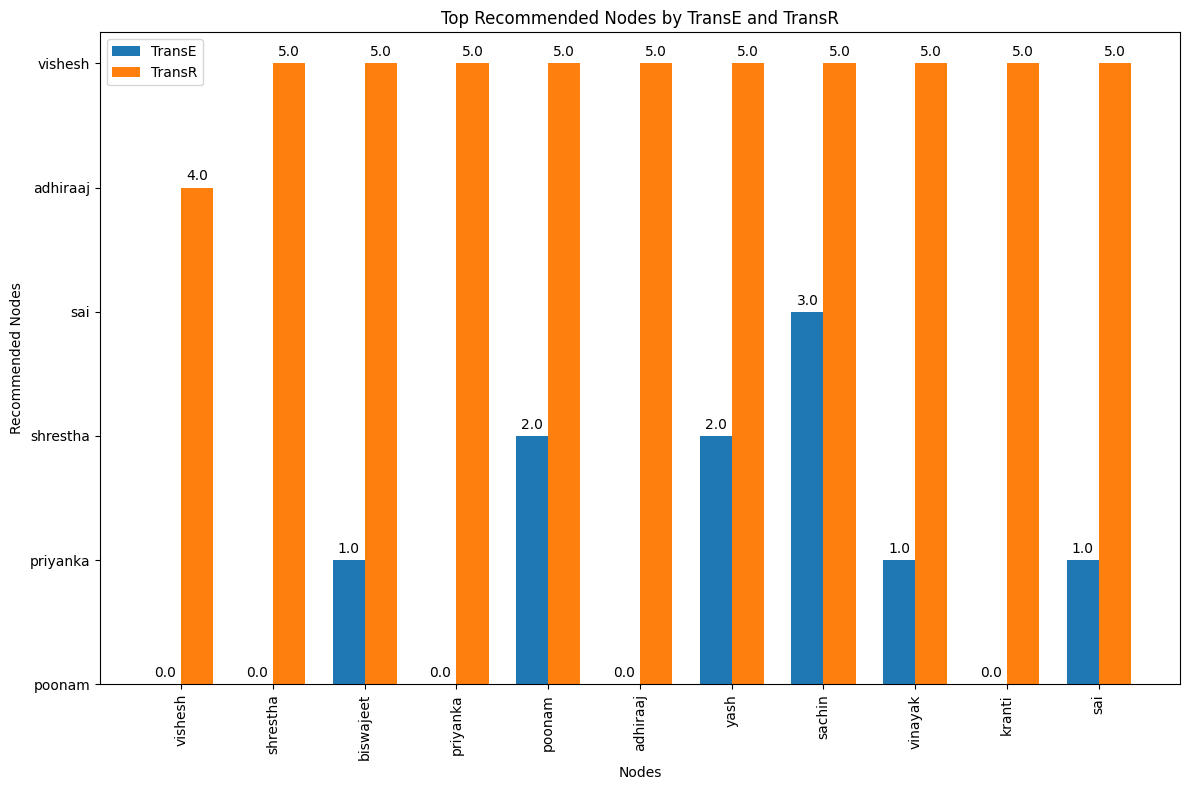

In [7]:
import matplotlib.pyplot as plt

# Prepare data for plotting
nodes = labels
transe_recommendations = [recommendations['TransE'][node] for node in nodes]
transr_recommendations = [recommendations['TransR'][node] for node in nodes]

# Create a bar chart
x = np.arange(len(nodes))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width/2, transe_recommendations, width, label='TransE')
rects2 = ax.bar(x + width/2, transr_recommendations, width, label='TransR')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Nodes')
ax.set_ylabel('Recommended Nodes')
ax.set_title('Top Recommended Nodes by TransE and TransR')
ax.set_xticks(x)
ax.set_xticklabels(nodes, rotation=90)
ax.legend()

# Function to add labels on the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [5]:
import pandas as pd
import numpy as np
import torch
import json
# Load the labels
labels = pd.read_csv('labelele.csv')['Names'].tolist()
labels = [label.strip() for label in labels]  # Strip whitespace from labels

# Create a mapping from labels to indices
label_to_index = {label: idx for idx, label in enumerate(labels)}

# Load the models
transr_model = torch.load('transr_model.pth')
transe_model = torch.load('transe_model.pth')

def get_top_recommendation(model, node, labels, label_to_index):
    relation = 'connected_to'
    possible_triples = np.array([[node, relation, target] for target in labels if target != node])
    possible_triples_indices = np.array([[label_to_index[h], 0, label_to_index[t]] for h, r, t in possible_triples])
    possible_triples_tensor = torch.tensor(possible_triples_indices, dtype=torch.long)
    scores = model.predict_hrt(possible_triples_tensor)
    scores_np = scores.detach().numpy()
    top_index = np.argmax(scores_np)
    top_triple = possible_triples_indices[top_index]
    similar_node = labels[top_triple[2]]
    return similar_node

# Get recommendations for each node using both models
recommendations = {'TransE': {}, 'TransR': {}}
for node in labels:
    recommendations['TransE'][node] = get_top_recommendation(transe_model, node, labels, label_to_index)
    recommendations['TransR'][node] = get_top_recommendation(transr_model, node, labels, label_to_index)

# Save recommendations to a file
with open('recommendations_transe.json', 'w') as f:
    json.dump(recommendations['TransE'], f)

with open('recommendations_transr.json', 'w') as f:
    json.dump(recommendations['TransR'], f)

# Print recommendations for verification
print("TransE Recommendations:", recommendations['TransE'])
print("TransR Recommendations:", recommendations['TransR'])

TransE Recommendations: {'vishesh': 'priyanka', 'shrestha': 'vinayak', 'biswajeet': 'vishesh', 'priyanka': 'vishesh', 'poonam': 'sachin', 'adhiraaj': 'kranti', 'yash': 'kranti', 'sachin': 'shrestha', 'vinayak': 'shrestha', 'kranti': 'vishesh', 'sai': 'vishesh'}
TransR Recommendations: {'vishesh': 'vinayak', 'shrestha': 'vishesh', 'biswajeet': 'vishesh', 'priyanka': 'vishesh', 'poonam': 'vishesh', 'adhiraaj': 'vishesh', 'yash': 'vishesh', 'sachin': 'vishesh', 'vinayak': 'vishesh', 'kranti': 'vishesh', 'sai': 'vishesh'}
